# Travail pratique N° 5 : CNN

## Les importations des modules et des librairies python:

In [153]:

#importations avec la fonction importations()
import importlib
import datapreprocessing
import neuralnetwork_models
import optimisationmodels
import cnn_layers_mini_batch
import toolsmethods

# Rechargement les modules pour prendre en compte les modifications sans redémarrer le kernel
importlib.reload(datapreprocessing)
importlib.reload(neuralnetwork_models)
importlib.reload(optimisationmodels)
importlib.reload(cnn_layers_mini_batch)
importlib.reload(toolsmethods)

from datapreprocessing import ImagesDataPreprocessingForCNN
from neuralnetwork_models import PersonalizedLeNet5
from optimisationmodels import AdamOptimizer , SGDOptimiser , MomentumOptimizer
from toolsmethods import ToolsMethods
from cnn_layers_mini_batch import ConvLayer, ActLayer, PoolLayer, Flatten, DenseLayer

from tqdm import tqdm #sert à afficher les barre de progression d'exécution.

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import os
from PIL import Image
import time

from sklearn.metrics import (accuracy_score , precision_score , recall_score , f1_score , confusion_matrix , ConfusionMatrixDisplay ,
classification_report)


### Chargement et prétraitement du Data:

In [5]:
X_train , X_val , X_test , y_train , y_val , y_test = ImagesDataPreprocessingForCNN.fit_transform(path= "amhcd-data-64", 
file_namesAndLabelsOfImages= "labels-map.csv", sizeOfImage= (32 , 32) , mode= 'Gray' ,  val_size= 0.2 , test_size= 0.2 ,
                                    stratification= True ,  sameResultOfSplit= True)

Téléchargement de 28182 échantillons avec 33 classes
Index(['image_path', 'label'], dtype='object')


100%|██████████| 28182/28182 [03:24<00:00, 137.57it/s]


In [6]:
# Vérification des dimensions des ensembles de train , de validation et de test
print("Shape de X_train:" , X_train.shape)
print("Shape de y_train:" , y_train.shape)
print("Shape de X_val:" , X_val.shape)
print("Shape de y_val:" , y_val.shape)
print("Shape de X_test:" , X_test.shape)
print("Shape de y_test:" , y_test.shape)

Shape de X_train: (16908, 32, 32)
Shape de y_train: (16908, 33)
Shape de X_val: (5637, 32, 32)
Shape de y_val: (5637, 33)
Shape de X_test: (5637, 32, 32)
Shape de y_test: (5637, 33)


In [9]:
# Réduction de la taille des données pour accélérer un peu l'entrainement en les convertissant en float32
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)
y_test  = y_test.astype(np.float32)


In [7]:
# Ajout une dimension pour le canal aux images
X_train = np.expand_dims(X_train , axis=-1)
X_val = np.expand_dims(X_val , axis=-1)
X_test = np.expand_dims(X_test , axis=-1)

In [10]:
# vérification de l'ajout du canal
print("Shape de X_train:" , X_train.shape)
print("Shape de y_train:" , y_train.shape)
print("Shape de X_val:" , X_val.shape)
print("Shape de y_val:" , y_val.shape)
print("Shape de X_test:" , X_test.shape)
print("Shape de y_test:" , y_test.shape)

Shape de X_train: (16908, 32, 32, 1)
Shape de y_train: (16908, 33)
Shape de X_val: (5637, 32, 32, 1)
Shape de y_val: (5637, 33)
Shape de X_test: (5637, 32, 32, 1)
Shape de y_test: (5637, 33)


### Construction des couches du réseau CNN:

In [11]:
conv1 = ConvLayer(numberOfChannels= 1 , numberOfFilters= 6 , sizeOfFilters= 5 , stride= 1 , padding= 0)
relu1 = ActLayer(activationFunction= 'relu')
pool1 = PoolLayer(pooling_type= 'avg' , window_size= (2 , 2) , stride= 2)
conv2 = ConvLayer(numberOfChannels= 6 , numberOfFilters= 16 , sizeOfFilters= 5 , stride= 1 , padding= 0)
relu2 = ActLayer(activationFunction= 'relu')
pool2 = PoolLayer(pooling_type= 'avg' , window_size= (2 , 2) , stride= 2)

flatten = Flatten()

dense1 = DenseLayer(numberOfNeurons= 120 , numberOfInputs= 5*5*16 , activationFunction= 'relu')
dense2 = DenseLayer(numberOfNeurons= 84  , numberOfInputs= 120    , activationFunction= 'relu')
sortie = DenseLayer(numberOfNeurons= 33  , numberOfInputs= 84     , activationFunction= 'softmax')

layers = [conv1 , relu1 , pool1 , conv2 , relu2 , pool2 , flatten , dense1 , dense2 , sortie]


In [12]:
model1 = PersonalizedLeNet5(layers= layers , optimizer= 'SGD' , learning_rate= 0.01 , _lambda= 0.01)

Nombre de couches = 10
[0] -> type: <class 'cnn_layers_mini_batch.ConvLayer'>, isinstance: True
[1] -> type: <class 'cnn_layers_mini_batch.ActLayer'>, isinstance: True
[2] -> type: <class 'cnn_layers_mini_batch.PoolLayer'>, isinstance: True
[3] -> type: <class 'cnn_layers_mini_batch.ConvLayer'>, isinstance: True
[4] -> type: <class 'cnn_layers_mini_batch.ActLayer'>, isinstance: True
[5] -> type: <class 'cnn_layers_mini_batch.PoolLayer'>, isinstance: True
[6] -> type: <class 'cnn_layers_mini_batch.Flatten'>, isinstance: True
[7] -> type: <class 'cnn_layers_mini_batch.DenseLayer'>, isinstance: True
[8] -> type: <class 'cnn_layers_mini_batch.DenseLayer'>, isinstance: True
[9] -> type: <class 'cnn_layers_mini_batch.DenseLayer'>, isinstance: True


In [13]:
losses_train , losses_val , accuracies_train , accuracies_val = model1.train(X_train , y_train , X_val , y_val , epochs= 50 , batch_size= 32)

Entraînement du modèle::   2%|▏         | 1/50 [02:39<2:10:31, 159.82s/it]

 Epoch 0 ---> Train Loss: 0.6965 | Validation Loss : 0.7260 |Train Accuracy: 0.7717 | Validation Accuracy: 0.7578


Entraînement du modèle::   6%|▌         | 3/50 [05:42<1:22:09, 104.89s/it]

 Epoch 2 ---> Train Loss: 0.2482 | Validation Loss : 0.2996 |Train Accuracy: 0.9119 | Validation Accuracy: 0.8909


Entraînement du modèle::  10%|█         | 5/50 [08:10<1:03:52, 85.17s/it] 

 Epoch 4 ---> Train Loss: 0.2045 | Validation Loss : 0.2753 |Train Accuracy: 0.9270 | Validation Accuracy: 0.9040


Entraînement du modèle::  14%|█▍        | 7/50 [10:19<52:45, 73.61s/it]  

 Epoch 6 ---> Train Loss: 0.1267 | Validation Loss : 0.1848 |Train Accuracy: 0.9591 | Validation Accuracy: 0.9399


Entraînement du modèle::  18%|█▊        | 9/50 [12:41<49:39, 72.67s/it]

 Epoch 8 ---> Train Loss: 0.0790 | Validation Loss : 0.1406 |Train Accuracy: 0.9744 | Validation Accuracy: 0.9502


Entraînement du modèle::  22%|██▏       | 11/50 [15:11<48:15, 74.24s/it]

 Epoch 10 ---> Train Loss: 0.0866 | Validation Loss : 0.1562 |Train Accuracy: 0.9724 | Validation Accuracy: 0.9473


Entraînement du modèle::  26%|██▌       | 13/50 [17:24<43:18, 70.24s/it]

 Epoch 12 ---> Train Loss: 0.0725 | Validation Loss : 0.1342 |Train Accuracy: 0.9746 | Validation Accuracy: 0.9539


Entraînement du modèle::  30%|███       | 15/50 [19:44<41:14, 70.69s/it]

 Epoch 14 ---> Train Loss: 0.0439 | Validation Loss : 0.1005 |Train Accuracy: 0.9882 | Validation Accuracy: 0.9666


Entraînement du modèle::  32%|███▏      | 16/50 [22:44<42:03, 74.23s/it]

 Epoch 16 ---> Train Loss: 0.0369 | Validation Loss : 0.0876 |Train Accuracy: 0.9903 | Validation Accuracy: 0.9729


Entraînement du modèle::  38%|███▊      | 19/50 [25:08<39:14, 75.97s/it]

 Epoch 18 ---> Train Loss: 0.0465 | Validation Loss : 0.1028 |Train Accuracy: 0.9875 | Validation Accuracy: 0.9674


Entraînement du modèle::  42%|████▏     | 21/50 [27:21<34:20, 71.04s/it]

 Epoch 20 ---> Train Loss: 0.0407 | Validation Loss : 0.0897 |Train Accuracy: 0.9885 | Validation Accuracy: 0.9698


Entraînement du modèle::  46%|████▌     | 23/50 [29:39<31:39, 70.35s/it]

 Epoch 22 ---> Train Loss: 0.0335 | Validation Loss : 0.0789 |Train Accuracy: 0.9923 | Validation Accuracy: 0.9745


Entraînement du modèle::  50%|█████     | 25/50 [31:51<28:24, 68.16s/it]

 Epoch 24 ---> Train Loss: 0.0834 | Validation Loss : 0.1385 |Train Accuracy: 0.9758 | Validation Accuracy: 0.9569


Entraînement du modèle::  54%|█████▍    | 27/50 [34:01<25:29, 66.52s/it]

 Epoch 26 ---> Train Loss: 0.0595 | Validation Loss : 0.1139 |Train Accuracy: 0.9817 | Validation Accuracy: 0.9640


Entraînement du modèle::  58%|█████▊    | 29/50 [36:17<23:30, 67.15s/it]

 Epoch 28 ---> Train Loss: 0.0640 | Validation Loss : 0.1177 |Train Accuracy: 0.9798 | Validation Accuracy: 0.9606


Entraînement du modèle::  62%|██████▏   | 31/50 [38:24<20:41, 65.34s/it]

 Epoch 30 ---> Train Loss: 0.0372 | Validation Loss : 0.0799 |Train Accuracy: 0.9911 | Validation Accuracy: 0.9759


Entraînement du modèle::  66%|██████▌   | 33/50 [40:29<18:03, 63.74s/it]

 Epoch 32 ---> Train Loss: 0.0394 | Validation Loss : 0.0937 |Train Accuracy: 0.9902 | Validation Accuracy: 0.9725


Entraînement du modèle::  70%|███████   | 35/50 [42:33<15:45, 63.03s/it]

 Epoch 34 ---> Train Loss: 0.0327 | Validation Loss : 0.0787 |Train Accuracy: 0.9915 | Validation Accuracy: 0.9761


Entraînement du modèle::  74%|███████▍  | 37/50 [44:41<13:45, 63.46s/it]

 Epoch 36 ---> Train Loss: 0.0487 | Validation Loss : 0.1043 |Train Accuracy: 0.9882 | Validation Accuracy: 0.9674


 Epoch 38 ---> Train Loss: 0.0601 | Validation Loss : 0.1171 |Train Accuracy: 0.9827 | Validation Accuracy: 0.9624


Entraînement du modèle::  82%|████████▏ | 41/50 [49:47<10:50, 72.29s/it]

 Epoch 40 ---> Train Loss: 0.0475 | Validation Loss : 0.1065 |Train Accuracy: 0.9865 | Validation Accuracy: 0.9663


Entraînement du modèle::  86%|████████▌ | 43/50 [52:01<08:06, 69.46s/it]

 Epoch 42 ---> Train Loss: 0.0993 | Validation Loss : 0.1614 |Train Accuracy: 0.9752 | Validation Accuracy: 0.9519


Entraînement du modèle::  90%|█████████ | 45/50 [54:09<05:33, 66.71s/it]

 Epoch 44 ---> Train Loss: 0.0374 | Validation Loss : 0.0914 |Train Accuracy: 0.9898 | Validation Accuracy: 0.9723


Entraînement du modèle::  94%|█████████▍| 47/50 [56:23<03:21, 67.01s/it]

 Epoch 46 ---> Train Loss: 0.0330 | Validation Loss : 0.0864 |Train Accuracy: 0.9921 | Validation Accuracy: 0.9721


Entraînement du modèle::  98%|█████████▊| 49/50 [58:33<01:05, 65.96s/it]

 Epoch 48 ---> Train Loss: 0.0848 | Validation Loss : 0.1428 |Train Accuracy: 0.9752 | Validation Accuracy: 0.9557


Entraînement du modèle:: 100%|██████████| 50/50 [59:39<00:00, 71.59s/it]


### Sauvegarde du modèle optimisé avec SGD:

In [102]:
ToolsMethods.save_model(model= model1 , fileName= "model_with_SGD.pkl")

 Modèle sauvegardé avec succès dans le fichier 'C:\Users\OUABOU\workspace\TP Deep learning\tp5_Le_Net_5\model_with_SGD.pkl'.


### Affichage des courbes d'apprentissage et matrices de confusion de train et de validation:

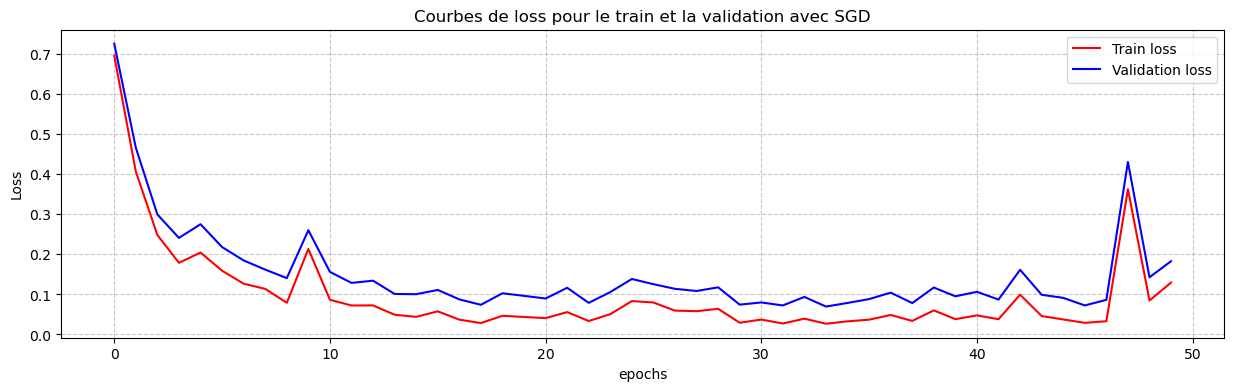

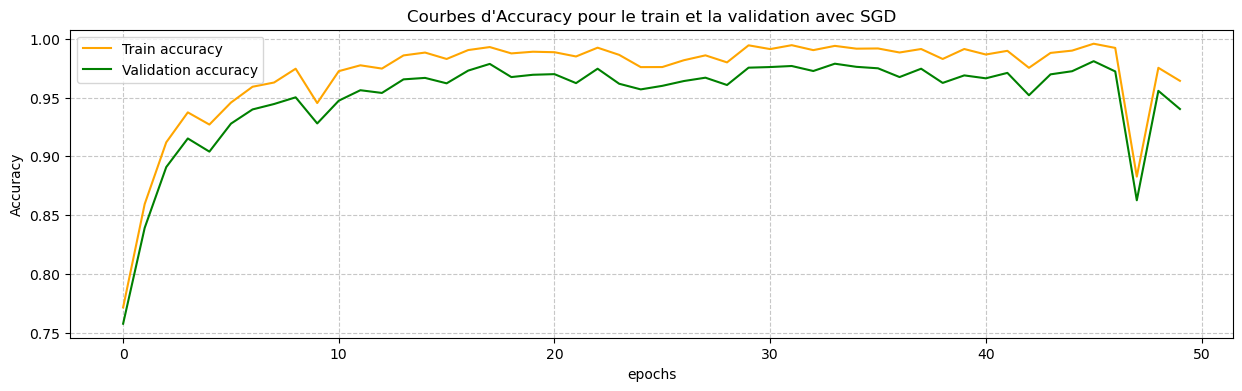

In [156]:
# préparation des arguments à passer pour la fonction de graphe 'multyCurvesGraph'
courbeListLoss = [losses_train , losses_val]
labelsListLoss = ['Train loss' , 'Validation loss']
titreLoss = 'Courbes de loss pour le train et la validation avec SGD'

courbeListAccuracy = [accuracies_train , accuracies_val]
labelsListAccuracy = ['Train accuracy' , 'Validation accuracy']
titreAccuracy = "Courbes d'Accuracy pour le train et la validation avec SGD"

# affichage des courbes de loss et d'accuracy pour les deux ensembles Train et Validation  
ToolsMethods.multiCurvesGraph(courbeListLoss , labelsListLoss , titreLoss)  #courbes de loss
ToolsMethods.multiCurvesGraph(courbeListAccuracy , labelsListAccuracy , titreAccuracy , ['orange' , 'green'] ) #courbes d'accuracy

In [ ]:
plt.savefig("courbes_SGD.png", dpi=300, bbox_inches='tight')

In [15]:
#les prédiction pour les ensembles de train, de validation et de test(Evaluation)
y_pred_train = model1.predict(X_train)
y_pred_test  = model1.predict(X_test)
y_pred_val   = model1.predict(X_val)

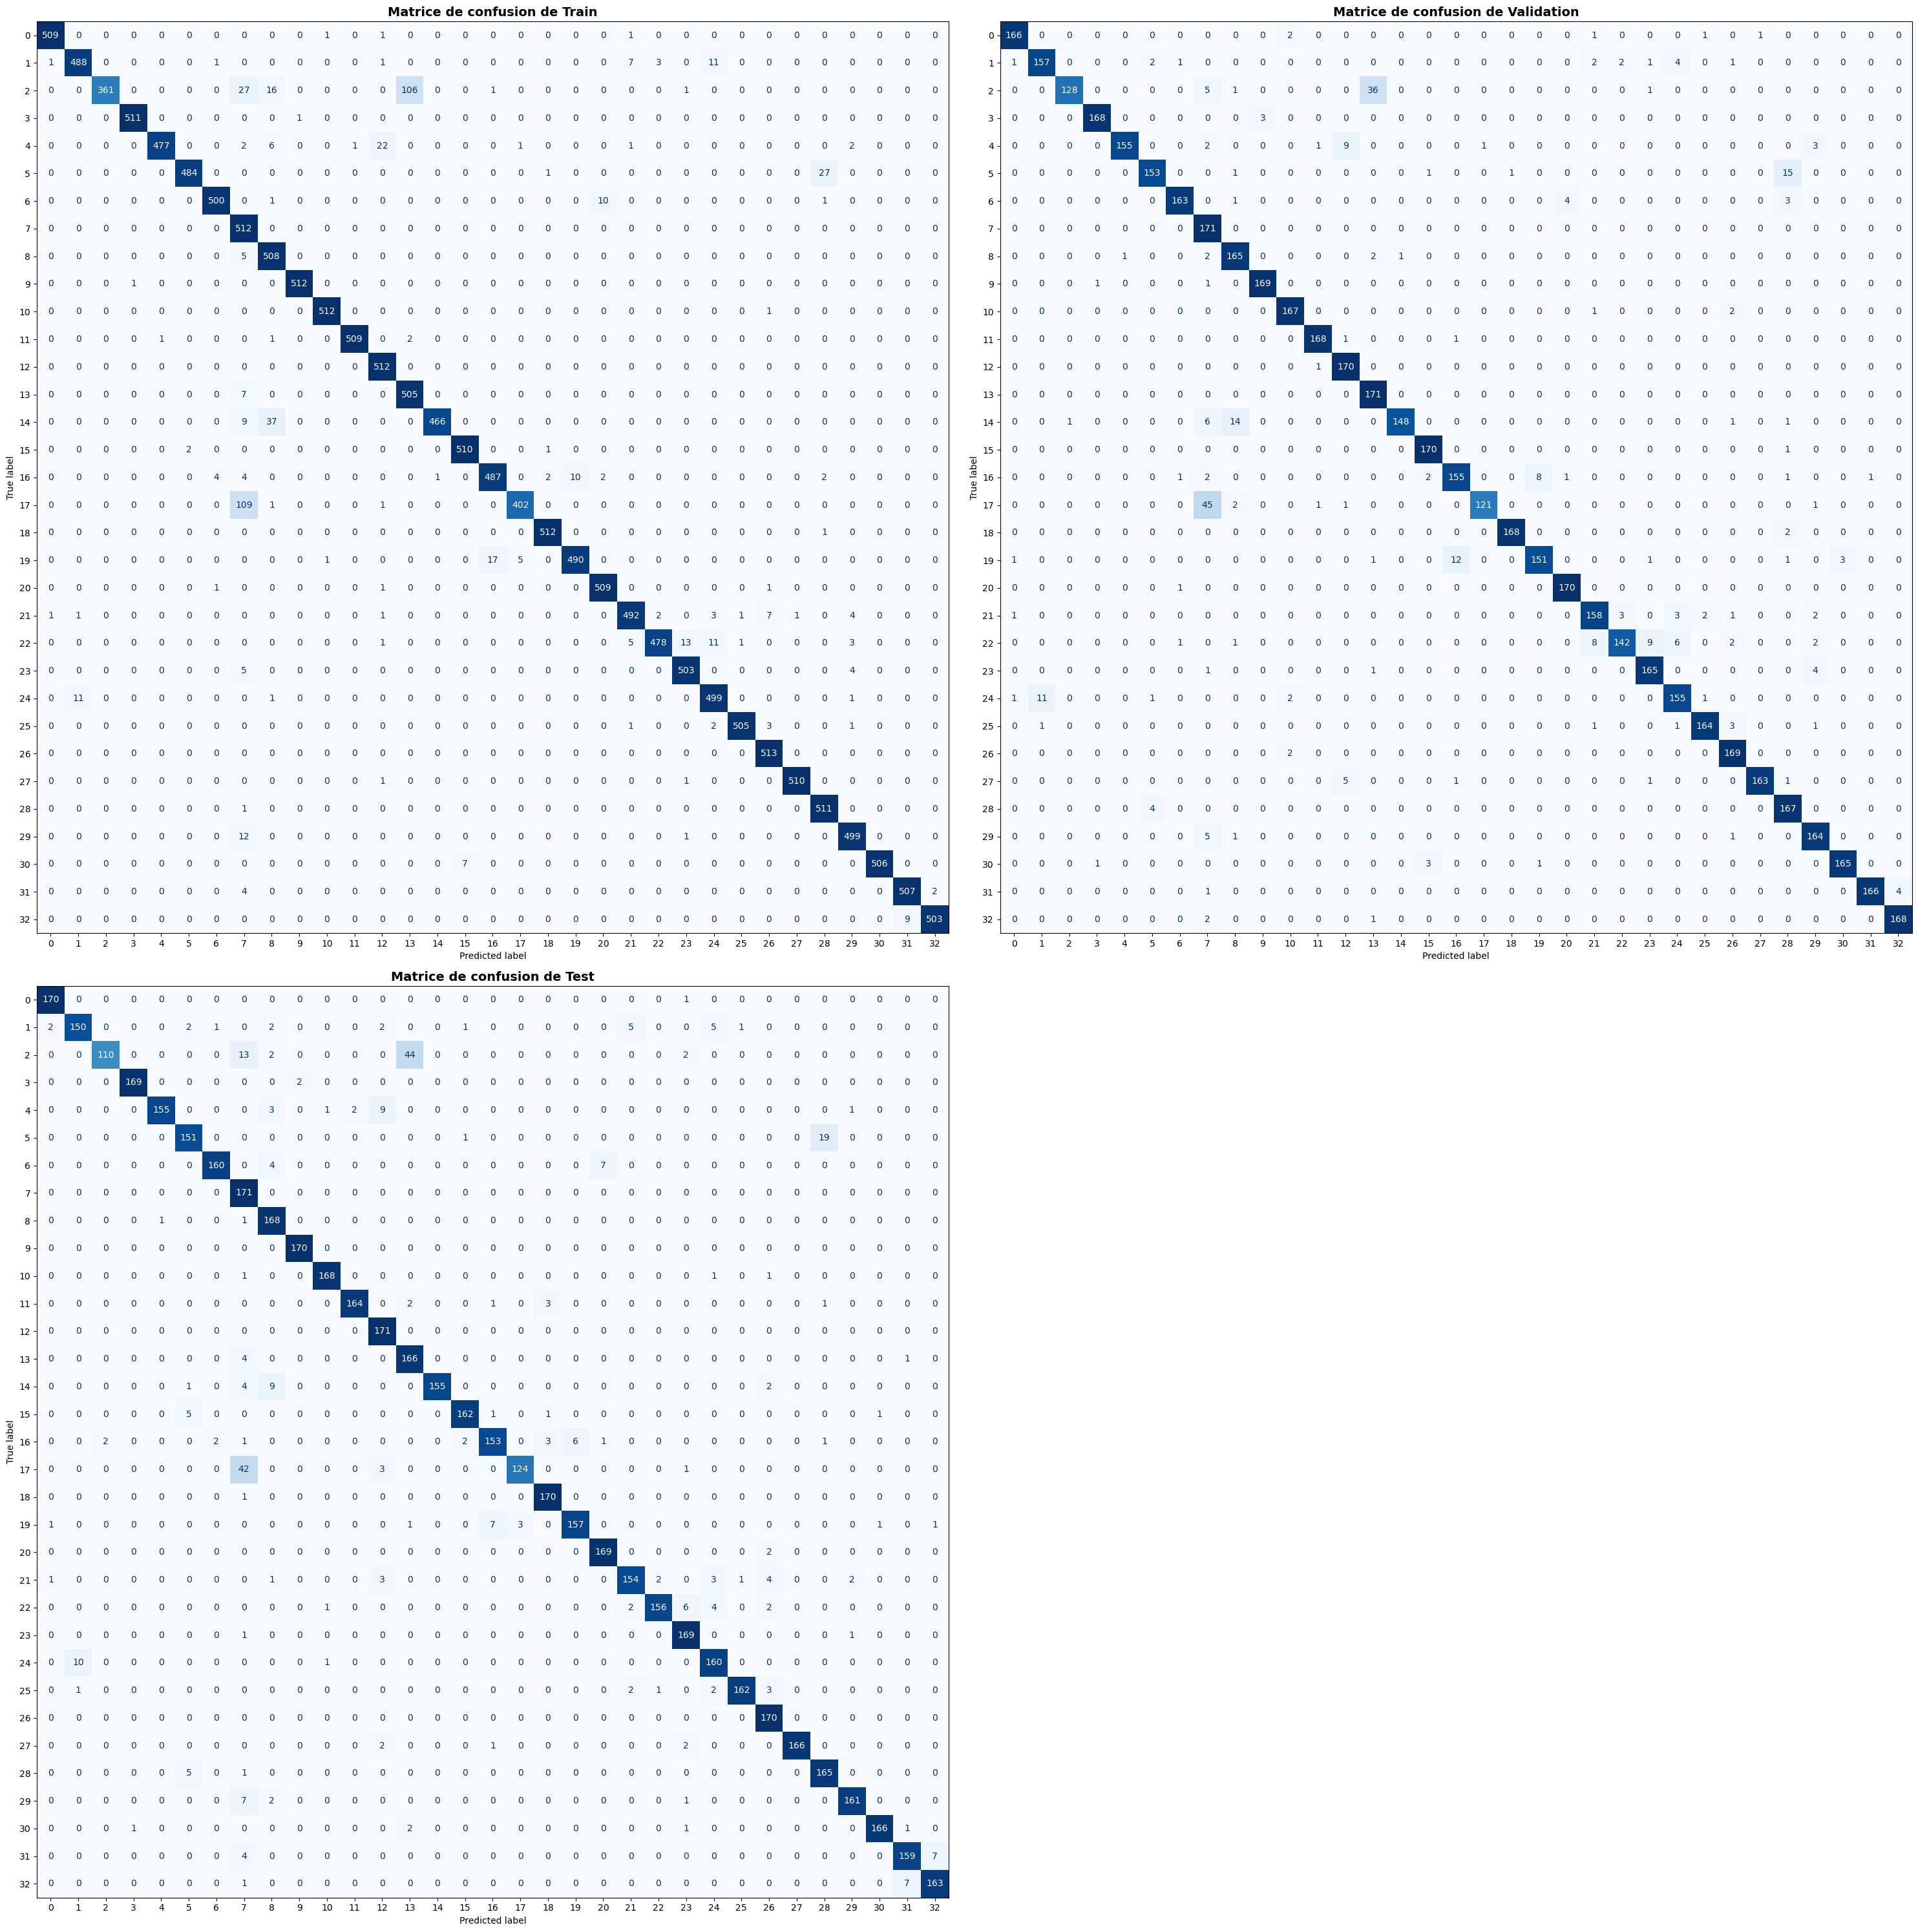

In [145]:
#les matrices de confusions et l'affichage des erreurs de classification comises par le modèle
cm_train = confusion_matrix(np.argmax(y_train , axis= 1) , y_pred_train)
cm_test  = confusion_matrix(np.argmax(y_test , axis= 1) , y_pred_test)
cm_val   = confusion_matrix(np.argmax(y_val , axis= 1) , y_pred_val)

#Affichage des matrices de confusion
labels_list =[(np.unique(np.argmax(y_train , axis= 1)).T).tolist()]*3
ToolsMethods.multiConfusionMatrices([cm_train , cm_val , cm_test] , labels_list ,
                                    ['Matrice de confusion de Train' , 'Matrice de confusion de Validation' , 'Matrice de confusion de Test'])

### Métriques d'évaluation du modèle:

In [17]:
###################################################################   évaluation  ###################################################################

#les métriques d'évaluation pour les ensembles de train, de validation et de test(Evaluation)
#on a choisit ici average 'macro' car les classes sont équilibrées

    #scores d'entraînement (ensemble de train)
trainScoreAccuracy  = accuracy_score(np.argmax(y_train , axis= 1) , y_pred_train)
trainScorePrecision = precision_score(np.argmax(y_train , axis= 1) , y_pred_train , average='macro')
trainScoreRecall    = recall_score(np.argmax(y_train , axis= 1) , y_pred_train , average='macro')
trainScoreF1        = f1_score(np.argmax(y_train , axis= 1) , y_pred_train  , average='macro')
    #scores de validation (ensemble de validation)
valScoreAccuracy  = accuracy_score(np.argmax(y_val , axis= 1) , y_pred_val)
valScorePrecision = precision_score(np.argmax(y_val , axis= 1) , y_pred_val , average='macro')
valScoreRecall    = recall_score(np.argmax(y_val , axis= 1) , y_pred_val , average='macro') 
valScoreF1        = f1_score(np.argmax(y_val , axis= 1) , y_pred_val , average='macro')
    #scores de l'Evaluation(ensemble de test)
testScoreAccuracy  = accuracy_score(np.argmax(y_test , axis= 1) , y_pred_test)
testScorePrecision = precision_score(np.argmax(y_test , axis= 1) , y_pred_test , average='macro')
testScoreRecall    = recall_score(np.argmax(y_test , axis= 1) , y_pred_test , average='macro')
testScoreF1        = f1_score(np.argmax(y_test , axis= 1) , y_pred_test , average='macro')

    #rapport total des métriques sur les trois ensembles (Train, Validation, Test)
total_metrics_report = {'Entraînement (Ensemble de Train)': { 'Accuracy': trainScoreAccuracy ,
                                                              'Precision': trainScorePrecision ,
                                                              'Recall': trainScoreRecall , 
                                                              'F1': trainScoreF1} ,
                        'Validation (Ensemble de validation)': {'Accuracy': valScoreAccuracy ,
                                                              'Precision': valScorePrecision ,
                                                              'Recall': valScoreRecall , 
                                                              'F1': valScoreF1} ,
                        'Evaluation (Ensemble de Test)': {    'Accuracy': testScoreAccuracy ,
                                                              'Precision': testScorePrecision ,
                                                              'Recall': testScoreRecall , 
                                                              'F1': testScoreF1}
                   }
    #affichage du rapport sous forme d'une DataFrame
display(pd.DataFrame(total_metrics_report))


,Entraînement (Ensemble de Train),Validation (Ensemble de validation),Evaluation (Ensemble de Test)
Accuracy,0.964159,0.940216,0.937378
Precision,0.968584,0.946160,0.944402
Recall,0.964155,0.940235,0.937375
F1,0.964113,0.940186,0.937359


## L'entrainnement du modèle avec l'optimiseur Adam:

### Construction du modèle: model2

In [66]:
con1 = ConvLayer(numberOfChannels= 1 , numberOfFilters= 6 , sizeOfFilters= 5 , stride= 1 , padding= 0)
activ1 = ActLayer(activationFunction= 'relu')
poo1 = PoolLayer(pooling_type= 'avg' , window_size= (2 , 2) , stride= 2)
con2 = ConvLayer(numberOfChannels= 6 , numberOfFilters= 16 , sizeOfFilters= 5 , stride= 1 , padding= 0)
activ2 = ActLayer(activationFunction= 'relu')
poo2 = PoolLayer(pooling_type= 'avg' , window_size= (2 , 2) , stride= 2)

flat = Flatten()

den1 = DenseLayer(numberOfNeurons= 120 , numberOfInputs= 5*5*16 , activationFunction= 'relu')
den2 = DenseLayer(numberOfNeurons= 84  , numberOfInputs= 120    , activationFunction= 'relu')
sort = DenseLayer(numberOfNeurons= 33  , numberOfInputs= 84     , activationFunction= 'softmax')

couches = [con1 , activ1 ,  poo1 , con2 , activ2 , poo2 , flat ,  den1 , den2 , sort]

In [67]:
model2 = PersonalizedLeNet5(layers= couches , optimizer= 'Adam' , learning_rate= 0.001 , _lambda= 0.0)

Nombre de couches = 10
[0] -> type: <class 'cnn_layers_mini_batch.ConvLayer'>, isinstance: True
[1] -> type: <class 'cnn_layers_mini_batch.ActLayer'>, isinstance: True
[2] -> type: <class 'cnn_layers_mini_batch.PoolLayer'>, isinstance: True
[3] -> type: <class 'cnn_layers_mini_batch.ConvLayer'>, isinstance: True
[4] -> type: <class 'cnn_layers_mini_batch.ActLayer'>, isinstance: True
[5] -> type: <class 'cnn_layers_mini_batch.PoolLayer'>, isinstance: True
[6] -> type: <class 'cnn_layers_mini_batch.Flatten'>, isinstance: True
[7] -> type: <class 'cnn_layers_mini_batch.DenseLayer'>, isinstance: True
[8] -> type: <class 'cnn_layers_mini_batch.DenseLayer'>, isinstance: True
[9] -> type: <class 'cnn_layers_mini_batch.DenseLayer'>, isinstance: True


### Entraînement du modèle avec Adam:

In [68]:
losses_train2 , losses_val2 , accuracies_train2 , accuracies_val2 = model2.train(X_train , y_train , X_val , y_val ,  epochs= 50 , batch_size= 64)

 Epoch 0 ---> Train Loss: 1.1469 | Validation Loss : 1.1910 |Train Accuracy: 0.6651 | Validation Accuracy: 0.6473


Entraînement du modèle::   6%|▌         | 3/50 [04:25<1:10:04, 89.45s/it]

 Epoch 2 ---> Train Loss: 0.4385 | Validation Loss : 0.4786 |Train Accuracy: 0.8662 | Validation Accuracy: 0.8540


Entraînement du modèle::  10%|█         | 5/50 [06:28<54:02, 72.06s/it]  

 Epoch 4 ---> Train Loss: 0.3307 | Validation Loss : 0.3635 |Train Accuracy: 0.8879 | Validation Accuracy: 0.8794


Entraînement du modèle::  14%|█▍        | 7/50 [08:25<46:19, 64.63s/it]

 Epoch 6 ---> Train Loss: 0.2034 | Validation Loss : 0.2536 |Train Accuracy: 0.9315 | Validation Accuracy: 0.9101


Entraînement du modèle::  18%|█▊        | 9/50 [10:27<42:51, 62.73s/it]

 Epoch 8 ---> Train Loss: 0.1493 | Validation Loss : 0.2035 |Train Accuracy: 0.9494 | Validation Accuracy: 0.9273


Entraînement du modèle::  22%|██▏       | 11/50 [12:29<40:07, 61.74s/it]

 Epoch 10 ---> Train Loss: 0.0865 | Validation Loss : 0.1412 |Train Accuracy: 0.9736 | Validation Accuracy: 0.9555


Entraînement du modèle::  26%|██▌       | 13/50 [14:41<39:44, 64.46s/it]

 Epoch 12 ---> Train Loss: 0.0991 | Validation Loss : 0.1649 |Train Accuracy: 0.9661 | Validation Accuracy: 0.9425


Entraînement du modèle::  30%|███       | 15/50 [17:00<38:56, 66.77s/it]

 Epoch 14 ---> Train Loss: 0.0791 | Validation Loss : 0.1394 |Train Accuracy: 0.9716 | Validation Accuracy: 0.9507


Entraînement du modèle::  34%|███▍      | 17/50 [18:56<34:11, 62.16s/it]

 Epoch 16 ---> Train Loss: 0.0721 | Validation Loss : 0.1306 |Train Accuracy: 0.9752 | Validation Accuracy: 0.9572


Entraînement du modèle::  38%|███▊      | 19/50 [20:52<31:02, 60.07s/it]

 Epoch 18 ---> Train Loss: 0.0396 | Validation Loss : 0.1078 |Train Accuracy: 0.9890 | Validation Accuracy: 0.9638


Entraînement du modèle::  42%|████▏     | 21/50 [23:38<35:42, 73.89s/it]

 Epoch 20 ---> Train Loss: 0.0676 | Validation Loss : 0.1553 |Train Accuracy: 0.9779 | Validation Accuracy: 0.9517


Entraînement du modèle::  46%|████▌     | 23/50 [25:43<30:41, 68.20s/it]

 Epoch 22 ---> Train Loss: 0.0380 | Validation Loss : 0.0979 |Train Accuracy: 0.9878 | Validation Accuracy: 0.9684


Entraînement du modèle::  50%|█████     | 25/50 [28:48<34:43, 83.35s/it]

 Epoch 24 ---> Train Loss: 0.0211 | Validation Loss : 0.0735 |Train Accuracy: 0.9938 | Validation Accuracy: 0.9780


Entraînement du modèle::  54%|█████▍    | 27/50 [33:45<44:26, 115.93s/it]

 Epoch 26 ---> Train Loss: 0.0491 | Validation Loss : 0.1161 |Train Accuracy: 0.9836 | Validation Accuracy: 0.9651


Entraînement du modèle::  58%|█████▊    | 29/50 [38:33<45:49, 130.92s/it]

 Epoch 28 ---> Train Loss: 0.0170 | Validation Loss : 0.0857 |Train Accuracy: 0.9949 | Validation Accuracy: 0.9750


Entraînement du modèle::  62%|██████▏   | 31/50 [40:38<30:29, 96.27s/it] 

 Epoch 30 ---> Train Loss: 0.0273 | Validation Loss : 0.1065 |Train Accuracy: 0.9907 | Validation Accuracy: 0.9682


Entraînement du modèle::  66%|██████▌   | 33/50 [42:53<22:53, 80.78s/it]

 Epoch 32 ---> Train Loss: 0.0272 | Validation Loss : 0.1011 |Train Accuracy: 0.9915 | Validation Accuracy: 0.9681


Entraînement du modèle::  70%|███████   | 35/50 [46:24<24:20, 97.34s/it]

 Epoch 34 ---> Train Loss: 0.0282 | Validation Loss : 0.1050 |Train Accuracy: 0.9905 | Validation Accuracy: 0.9670


Entraînement du modèle::  74%|███████▍  | 37/50 [49:57<22:57, 105.96s/it]

 Epoch 36 ---> Train Loss: 0.0169 | Validation Loss : 0.0845 |Train Accuracy: 0.9953 | Validation Accuracy: 0.9725


Entraînement du modèle::  78%|███████▊  | 39/50 [55:35<25:24, 138.59s/it]

 Epoch 38 ---> Train Loss: 0.0139 | Validation Loss : 0.0842 |Train Accuracy: 0.9960 | Validation Accuracy: 0.9723


Entraînement du modèle::  82%|████████▏ | 41/50 [57:38<14:53, 99.23s/it] 

 Epoch 40 ---> Train Loss: 0.0176 | Validation Loss : 0.0811 |Train Accuracy: 0.9955 | Validation Accuracy: 0.9750


Entraînement du modèle::  86%|████████▌ | 43/50 [59:39<09:14, 79.27s/it]

 Epoch 42 ---> Train Loss: 0.0326 | Validation Loss : 0.1106 |Train Accuracy: 0.9896 | Validation Accuracy: 0.9672


Entraînement du modèle::  90%|█████████ | 45/50 [1:01:41<05:49, 69.91s/it]

 Epoch 44 ---> Train Loss: 0.0164 | Validation Loss : 0.0862 |Train Accuracy: 0.9945 | Validation Accuracy: 0.9755


Entraînement du modèle::  94%|█████████▍| 47/50 [1:03:42<03:15, 65.13s/it]

 Epoch 46 ---> Train Loss: 0.0185 | Validation Loss : 0.1073 |Train Accuracy: 0.9941 | Validation Accuracy: 0.9670


Entraînement du modèle::  98%|█████████▊| 49/50 [1:05:39<01:01, 61.70s/it]

 Epoch 48 ---> Train Loss: 0.0105 | Validation Loss : 0.0687 |Train Accuracy: 0.9982 | Validation Accuracy: 0.9821


Entraînement du modèle:: 100%|██████████| 50/50 [1:06:38<00:00, 79.96s/it]


### Sauvegarde du modèle optimisé avec Adam:

In [101]:
ToolsMethods.save_model(model= model2 , fileName= "model_with_Adam.pkl")

 Modèle sauvegardé avec succès dans le fichier 'C:\Users\OUABOU\workspace\TP Deep learning\tp5_Le_Net_5\model_with_Adam.pkl'.


### Affichage des courbes d'apprentissage et matrices de confusion de train et de validation:

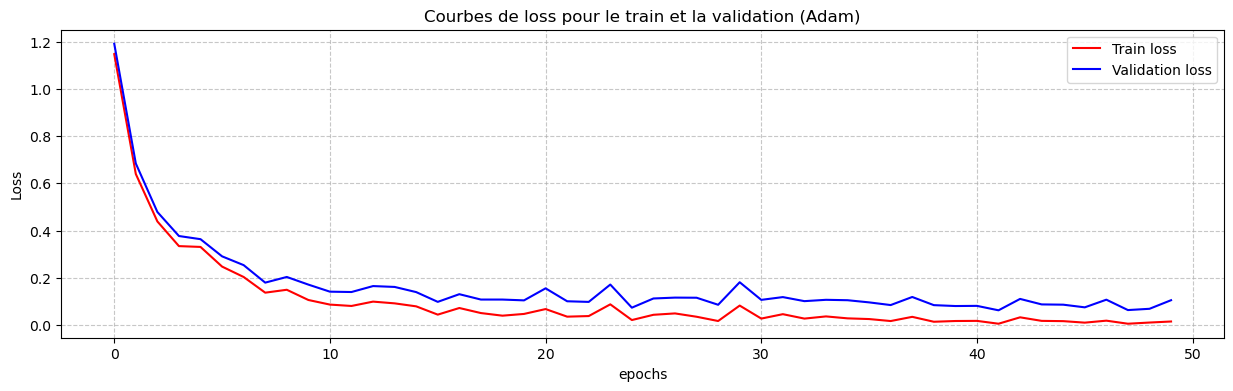

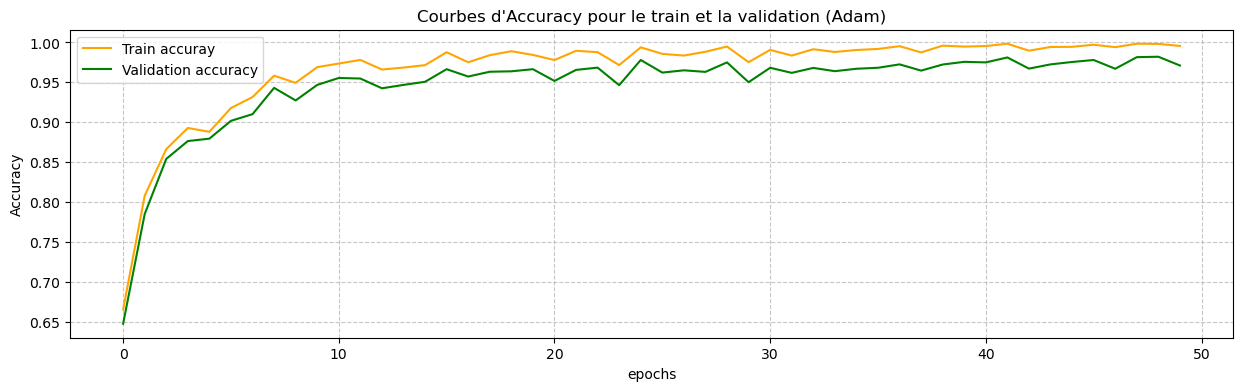

In [155]:
#affichage des courbes et mtrice de confusion de train et de validation

    #préparation des arguments à passer pour la fonction de graphe 'multyCurvesGraph'
courbeListLoss = [losses_train2 , losses_val2]
labelsListLoss = ['Train loss' , 'Validation loss']
titreLoss = 'Courbes de loss pour le train et la validation (Adam)'

courbeListAccuracy = [accuracies_train2 , accuracies_val2]
labelsListAccuracy = ['Train accuray' , 'Validation accuracy']
titreAccuracy = "Courbes d'Accuracy pour le train et la validation (Adam)"

     # affichage des courbes de loss et d'accuracy pour les deux ensembles Train et Validation  
ToolsMethods.multiCurvesGraph(courbeListLoss , labelsListLoss , titreLoss)  #courbes de loss
ToolsMethods.multiCurvesGraph(courbeListAccuracy , labelsListAccuracy , titreAccuracy , ['orange' , 'green'] ) #courbes d'accuracy

In [70]:
#les prédiction pour les ensembles de train, de validation et de test(Evaluation)
y_pred_train2 = model2.predict(X_train)
y_pred_test2  = model2.predict(X_test)
y_pred_val2   = model2.predict(X_val)

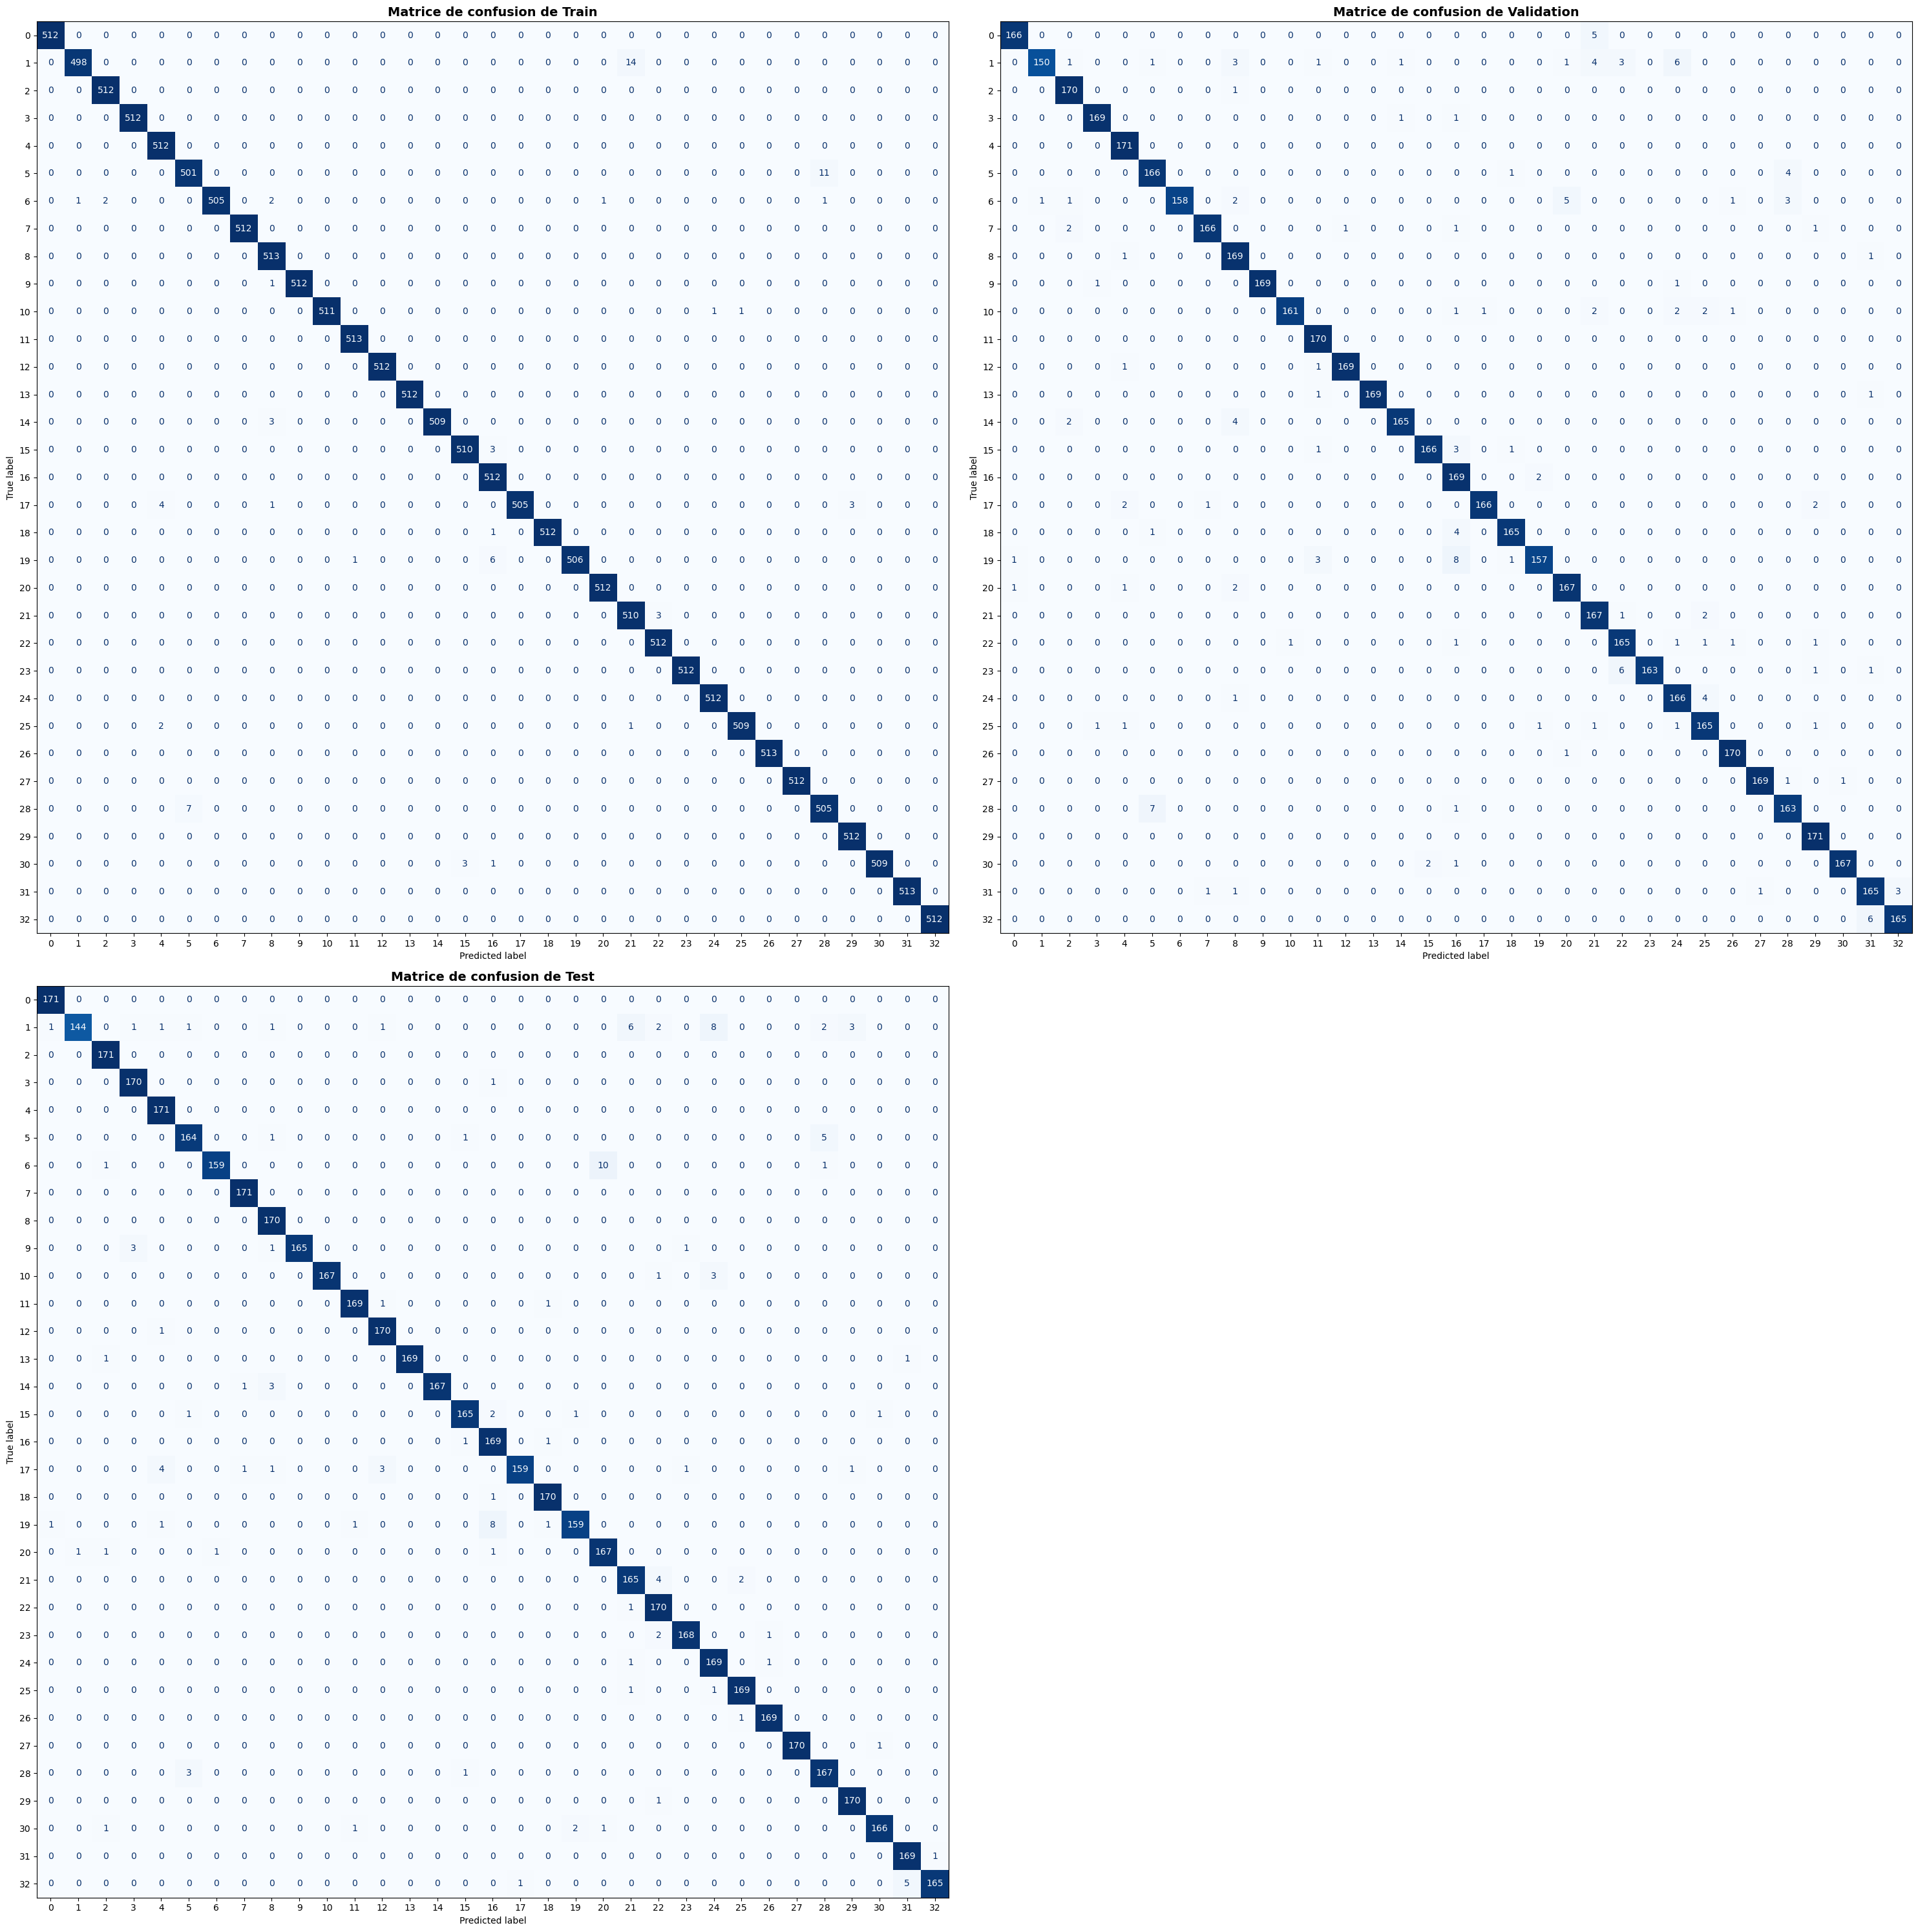

In [150]:
#les matrices de confusions et l'affichage des erreurs de classification comises par le modèle
cm_train2 = confusion_matrix(np.argmax(y_train , axis= 1) , y_pred_train2)
cm_test2  = confusion_matrix(np.argmax(y_test , axis= 1) , y_pred_test2)
cm_val2   = confusion_matrix(np.argmax(y_val , axis= 1) , y_pred_val2)

#Affichage des matrices de confusion
labels_list =[(np.unique(np.argmax(y_train , axis= 1)).T).tolist()]*3
ToolsMethods.multiConfusionMatrices([cm_train2 , cm_val2 , cm_test2] , labels_list ,
                                    ['Matrice de confusion de Train' , 'Matrice de confusion de Validation' , 'Matrice de confusion de Test'])

### Métriques d'évaluation du modèle: (model2)

In [75]:
###################################################################   évaluation  ###################################################################

#les métriques d'évaluation pour les ensembles de train, de validation et de test(Evaluation)
#on a choisit ici average 'macro' car les classes sont équilibrées

    #scores d'entraînement (ensemble de train)
trainScoreAccuracy2  = accuracy_score(np.argmax(y_train , axis= 1) , y_pred_train2)
trainScorePrecision2 = precision_score(np.argmax(y_train , axis= 1) , y_pred_train2 , average='macro')
trainScoreRecall2    = recall_score(np.argmax(y_train , axis= 1) , y_pred_train2 , average='macro')
trainScoreF12       = f1_score(np.argmax(y_train , axis= 1) , y_pred_train2  , average='macro')
    #scores de validation (ensemble de validation)
valScoreAccuracy2  = accuracy_score(np.argmax(y_val , axis= 1) , y_pred_val2)
valScorePrecision2 = precision_score(np.argmax(y_val , axis= 1) , y_pred_val2 , average='macro')
valScoreRecall2    = recall_score(np.argmax(y_val , axis= 1) , y_pred_val2 , average='macro') 
valScoreF12        = f1_score(np.argmax(y_val , axis= 1) , y_pred_val2 , average='macro')
    #scores de l'Evaluation(ensemble de test)
testScoreAccuracy2  = accuracy_score(np.argmax(y_test , axis= 1) , y_pred_test2)
testScorePrecision2 = precision_score(np.argmax(y_test , axis= 1) , y_pred_test2 , average='macro')
testScoreRecall2    = recall_score(np.argmax(y_test , axis= 1) , y_pred_test2 , average='macro')
testScoreF12        = f1_score(np.argmax(y_test , axis= 1) , y_pred_test2 , average='macro')

    #rapport total des métriques sur les trois ensembles (Train, Validation, Test)
total_metrics_report2 = {'Entraînement (Ensemble de Train)': { 'Accuracy': trainScoreAccuracy2 ,
                                                              'Precision': trainScorePrecision2 ,
                                                              'Recall': trainScoreRecall2 , 
                                                              'F1': trainScoreF12} ,
                        'Validation (Ensemble de validation)': {'Accuracy': valScoreAccuracy2 ,
                                                              'Precision': valScorePrecision2 ,
                                                              'Recall': valScoreRecall2 , 
                                                              'F1': valScoreF12} ,
                        'Evaluation (Ensemble de Test)': {    'Accuracy': testScoreAccuracy2 ,
                                                              'Precision': testScorePrecision2 ,
                                                              'Recall': testScoreRecall2 , 
                                                              'F1': testScoreF12}
                   }
    #affichage du rapport sous forme d'une DataFrame
display(pd.DataFrame(total_metrics_report2))


,Entraînement (Ensemble de Train),Validation (Ensemble de validation),Evaluation (Ensemble de Test)
Accuracy,0.995623,0.971084,0.976406
Precision,0.995672,0.971989,0.976987
Recall,0.995624,0.971080,0.976407
F1,0.995625,0.971105,0.976266


### Affichage des résultats d'application des filtres de convolution 'Conv1' sur une image

In [112]:
sortie_conv1 = model2.layers[2].inputMaps[0,:,:,:] # résultats des filtres activés avec 'ReLU'

In [109]:
sortie_conv2 = model2.layers[1].input_Z[0,:,:,:]

In [110]:
sortie_conv2.shape

(28, 28, 6)

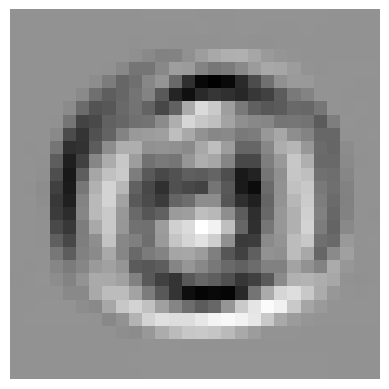

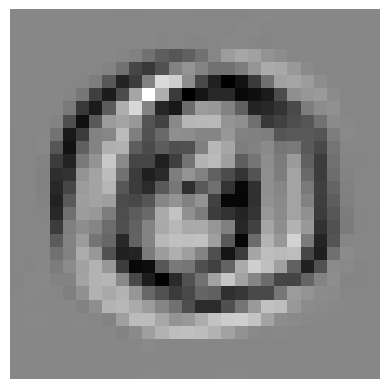

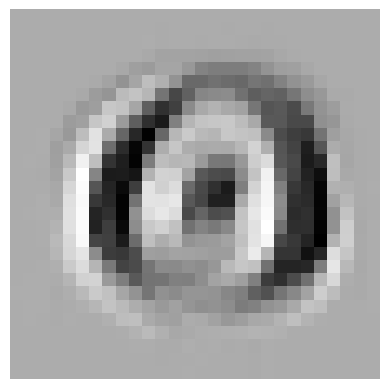

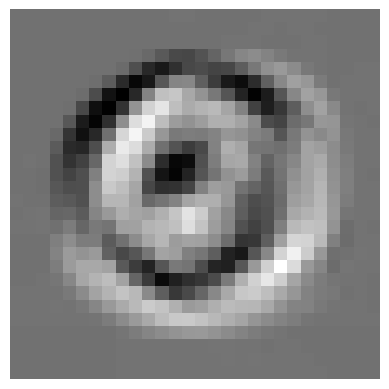

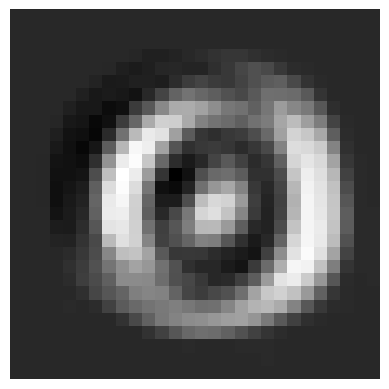

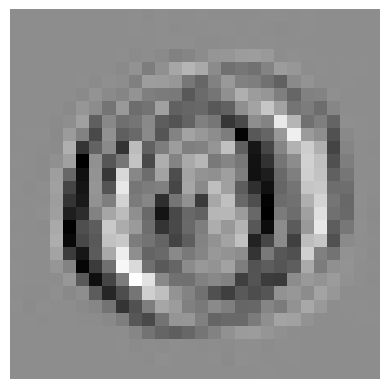

In [111]:
for i in range(6):
    plt.imshow(sortie_conv2[:,:,i]  , cmap = 'gray')
    plt.axis('off')  # Optionnel : supprimer les axes
    plt.show()